In [1]:
import os,sys,time,copy
import random
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.integrate import fixed_quad,quad 
#from  numba import jit,objmode,njit
from tqdm import tqdm



#--matplotlib
import matplotlib
from matplotlib.lines import Line2D
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rc('text',usetex=True)
import pylab as py
from matplotlib import colors
import matplotlib.gridspec as gridspec

#--torch
import torch
import torch.nn as nn
import torch.optim as optim

print(torch.cuda.is_available())
torch.cuda.empty_cache()
manualSeed = 999 # Set random seed for reproducibility
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
#torch.use_deterministic_algorithms(True) # Needed for reproducible results


<ipython-input-1-0460f86995e4>:15: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


True
Random Seed:  999


In [2]:
#! Number of GPUs available. Use 0 for CPU mode.
ngpu = 1 
#! Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [3]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        #nn.init.normal_(m.weight.data, 0.0, 0.7)
        nn.init.normal_(m.weight.data, 0.0, 0.1)



In [281]:
class Generator(nn.Module):
    def __init__(self, ngpu, dnoise,dfeatures):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        x=1
        self.main = nn.Sequential(
            nn.Linear(dnoise, x*dfeatures),
            )
    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self, ngpu,dfeatures):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        x=200
        self.main = nn.Sequential(
            nn.Linear(dfeatures, x*dfeatures),
            nn.ReLU(),
            nn.Linear(x*dfeatures, x*dfeatures),
            nn.ReLU(),
            nn.Linear(x*dfeatures, 1),
            nn.Sigmoid())        
    def forward(self, input):
        return self.main(input)



In [282]:
# Create the generator
dfeatures=10
dnoise=dfeatures
netG = Generator(ngpu,dnoise,dfeatures).to(device)
netG.apply(weights_init);
netD = Discriminator(ngpu,dfeatures).to(device)
netD.apply(weights_init);

In [283]:
netG_copy = copy.deepcopy(netG) 

In [284]:
class TDATA:
    
    def __init__(self,dfeatures,w=0.1):
        
        a=0.5; b=2
        x=np.linspace(0.1,0.9,dfeatures)
        f=x**a*(1-x)**b
        self.x=x 
        self.f=f
        self.w=w
    
    def gen_samples(self,batch):
        return self.f*(1+self.w*np.random.randn(batch,self.x.size))

In [285]:
tdata=TDATA(dfeatures,w=0.1)

In [286]:
def plot(ax,netG,option=1):
    
    if option==1:
        norm=1
    elif option==2:
        norm=1/tdata.f
    ax.plot(tdata.x,norm*tdata.f,'ko')

    samples=tdata.gen_samples(100)
    mean=norm*np.mean(samples,axis=0)
    std=norm*np.std(samples,axis=0)
    dx=0.02
    ax.errorbar(tdata.x+dx,mean,std,fmt='bs')
    for i in range(samples.shape[0]):
        ax.plot(tdata.x+dx,norm*samples[i],'bx',alpha=0.1)

        
    noise = torch.randn(10000,dnoise, device=device)
    fake=netG(noise).cpu().detach().numpy()
    for i in range(100):
        ax.plot(tdata.x+dx*2,norm*fake[i],'rx',alpha=0.1)
    mean=norm*np.mean(fake,axis=0)
    std=norm*np.std(fake,axis=0)
    ax.errorbar(tdata.x+dx*2,mean,std,fmt='rx')
    
    ax.set_xlim(0,1)


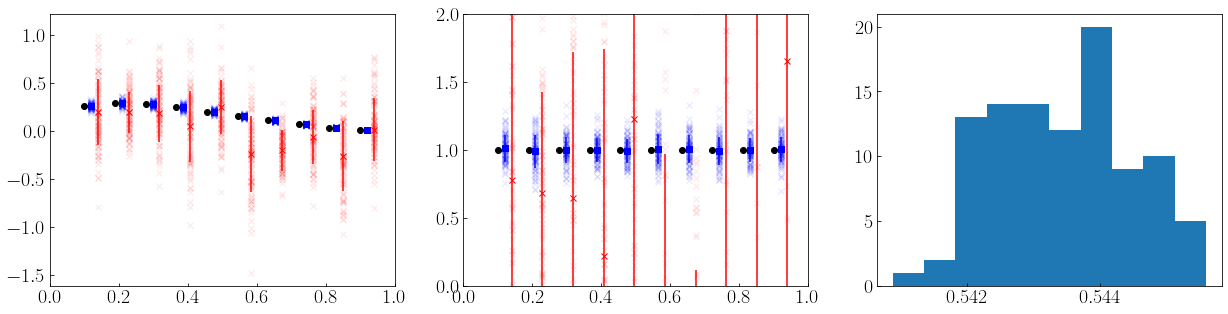

In [287]:
nrows,ncols=1,3
fig = py.figure(figsize=(ncols*7,nrows*5))

ax=py.subplot(nrows,ncols,1);ax1=ax
plot(ax,netG_copy,1)

ax=py.subplot(nrows,ncols,2);ax2=ax
plot(ax,netG_copy,2)
ax.set_ylim(0,2)
ax=py.subplot(nrows,ncols,3);ax3=ax
ax.hist(out[:,0]);

for ax in [ax1,ax2,ax3]:
    ax.tick_params(axis='both', which='major',labelsize=20,direction='in')


In [288]:
#! Initialize the ``BCELoss`` function
criterion = nn.BCELoss()
#criterion = nn.MSELoss()


#! Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

#! Learning rate for optimizers
lr = 0.0002
lr = 0.0002
#! Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

#! Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

G_losses = []
D_losses = []

In [289]:
batch=100
for epoch in tqdm(range(30000)):

    samples=tdata.gen_samples(batch)
    samples=torch.tensor(samples,dtype=torch.float32).to(device)
    
    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    b_size = samples.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    # Forward pass real batch through D
    output = netD(samples).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()
    D_x = output.mean().item()


    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size,dnoise, device=device)
    # Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output = netD(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = netD(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizerG.step()
    
    
    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())
    

100%|██████████| 30000/30000 [03:10<00:00, 157.75it/s]


In [290]:
def plot2(ax,netG,option=1):
    
    if option==1:
        norm=1
    elif option==2:
        norm=1/tdata.f
    ax.plot(tdata.x,norm*tdata.f,'ko')

    samples=tdata.gen_samples(1000)
    mean=norm*np.mean(samples,axis=0)
    std=norm*np.std(samples,axis=0)
    dx=0
    ax.fill_between(tdata.x+dx,mean-std,mean+std,color='b',alpha=0.2)
        
    noise = torch.randn(10000,dnoise, device=device)
    fake=netG(noise).cpu().detach().numpy()
    mean=norm*np.mean(fake,axis=0)
    std=norm*np.std(fake,axis=0)
    ax.fill_between(tdata.x+dx,mean-std,mean+std
                    ,color='none',edgecolor='r',hatch='...')

    ax.set_xlim(0,1)

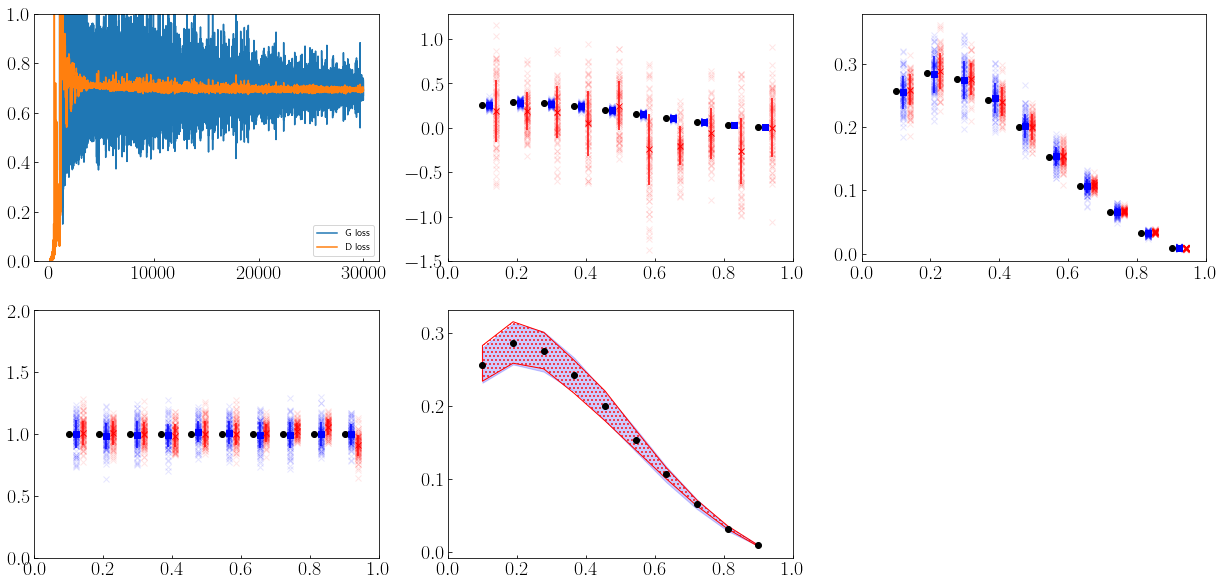

In [291]:
nrows,ncols=2,3
fig = py.figure(figsize=(ncols*7,nrows*5))
AX=[]
ax=py.subplot(nrows,ncols,1);AX.append(ax)
I=np.arange(len(G_losses))
ax.plot(I[100:],np.array(G_losses[100:]),label='G loss');
ax.plot(I[100:],np.array(D_losses[100:])/2,label='D loss');
ax.legend()
ax.set_ylim(0,1)

ax=py.subplot(nrows,ncols,2);AX.append(ax)
plot(ax,netG_copy)
ax=py.subplot(nrows,ncols,3);AX.append(ax)
plot(ax,netG)
ax=py.subplot(nrows,ncols,4);AX.append(ax)
plot(ax,netG,2)
ax.set_ylim(0,2)
ax=py.subplot(nrows,ncols,5);AX.append(ax)
plot2(ax,netG)

for ax in AX:
    ax.tick_params(axis='both', which='major',labelsize=20,direction='in')


In [ ]:
red = 0.25 + N*0.2         N -> 0.25 + N*0.2  

In [ ]:
f(x) = N*x**a*(1-x)**b

noise -> G -> (a,b)  -> f(x) -> 
noise -> G -> f(x)_i ->